In [2]:
import matplotlib.pyplot as plt 
import numpy as np
import emcee
import triangle
import matplotlib as mpl
%matplotlib inline

mpl.rcParams['axes.labelsize'] = 20

# Searching for signals in noise

In this post we will cover some simple ideas that can be used to 
search for a signal in noise. Typically these methods are most 
useful when we are in the low signal to noise (SNR) enviroment.
The aim to show a use of the excellent [emcee](http://dan.iel.fm/emcee/current/) package
written by Dan Foreman-Mackey.

This post is available as an `ipython notebook` and can be downloaded/viewed
[in nbviewer directly](http://nbviewer.ipython.org/github/ga7g08/ga7g08.github.io/blob/master/_notebooks/SearchingForSignalsInNoise.ipynb)

$\newcommand{\data}{\mathbf{X}_{\textrm{obs}}}$

## The basic idea
At discreet times $t_{i}$, we observe some data $\data(t_{i})$. The bold
font here indicates the data might be a vector of $N$ individual observations. We
hopefully have some ideas about the model which might have produced the data. 
Lets imagine we think this is the sum of a deterministic 'signal model'
and some noise process, that is

$$ X(t; \vec{\theta}) = f(t; \vec{\theta}) + n(t) $$ 

Here we use $\vec{\theta}$ a vector of length $d$ for the number of model
parameters. This is chosen on purpose to show the different between the
vectors of data, and those of parameters. 

The trick, which I learned from the gravitational-wave search community
is to make an assumption about the noise $n(t)$. Let's assume it is
stationary and normal such that the probability density function for 
$n(t)$ is the central normal distribution:

$$ N(0, \sigma) = \frac{1}{\sqrt{2\pi\sigma^{2}}}\exp\left\{ \frac{-x^{2}}{2\sigma^{2}}\right\} $$

Is this is the case, then if we knew the deterministic signal model
$f(t\; \vec{\theta}$ for the observed data, subtracting this from the
data should leave only the normally distributed noise.

$$ X(t; \vec{\theta}) - f(t; \vec{\theta}) \sim N(0, \sigma) $$ 

Therefore, given a single observed data point $X_{\textrm{obs}}(t_{i})$ and a
set of model parameters $\vec{\theta}$ we can compute the likelihood of that
data point:
$$ \mathcal{L} = p(X_{\textrm{obs}}(t_{i})| \vec{\theta}, \sigma) = \frac{1}{\sqrt{2\pi\sigma^{2}}}\exp\left\{ \frac{-\left(X_{\textrm{obs}}(t_{i}) - f(t_{i}; \vec{\theta})\right)^{2}}{2\sigma^{2}}\right\} $$

and so, provided all the data points are independant, the likelihood of all the
data points is given by their product

$$ \mathcal{L} = p(\data| \vec{\theta}, \sigma) = \prod_{i}^{N} \frac{1}{\sqrt{2\pi\sigma^{2}}}\exp\left\{ \frac{-\left(X_{\textrm{obs}}(t_{i}) - f(t_{i}; \vec{\lambda})\right)^{2}}{2\sigma^{2}}\right\} $$

Writing this as the log-likelilhood
\begin{equation}
\log\left(\mathcal{L}\right) = -\frac{1}{2}\sum_{i=1}^{N}\left(
\frac{\left(X_{\textrm{obs}}(t_{i})-f(t_{i}; \vec{\theta})\right)^{2}}{\sigma^{2}} + \log(2\pi\sigma^{2})
\right)
\end{equation}

## Parameter estimation

Having obtained an expression for the likelihood of some data given some fixed 
parameters we are now in a position to use [Bayes theorem](http://en.wikipedia.org/wiki/Bayes%27_theorem)
to estimate which parameter best fit the data. This is done by writting 
down the proportional version of Bayes rule:

$$ p(\vec{\theta}| \data) \propto p(\data| \vec{\theta}) p(\vec{\theta}) $$

Notice that we have a method to compute the likelihood term 
$p(\data| \vec{\theta}) = \mathcal{L}$ above. All that is left is
for us to specify the 'prior' $p(\vec{\theta}$: for now we will use
non-informative uniform priors. 

We are now in a possition to use the `emcee` package to estimate the posterior
parameter probabilties. See the [example in the docs](http://dan.iel.fm/emcee/current/user/line/)
for a far better explanation of all that I've just said!



## Example

To illustrate the idea here is a simple example. Lets define the deterministic
model to be
$$ f(t; X_{0}, A, f) = X_{0} + A * \sin(2\pi f t) $$


### Fake data

First we define the 'real' parameters, usually these would be
precisely what we don't know and want to specify.

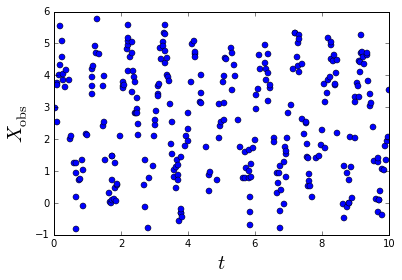

In [18]:
# Model parameters
A = 2.3
f = 1
X0 = 2.5

# Noise parameter
sigma = 0.6

N = 300
t = np.sort(np.random.uniform(0, 10, N))
X = X0 + A * np.sin(2 * np.pi * f * t) + np.random.normal(0, sigma, N)

plt.plot(t, X, "o")
plt.xlabel("$t$")
plt.ylabel(r"$X_{\mathrm{obs}}$")
plt.show()


### Marginalisation

We will now use the MCMC algorithms of `emcee` to explore the 
joint probability distributions of the parameters. 

First we must define log-likelihood and log-prior in code. We
will introduce two generic functions which can be used for any
sigal model. If this is unfamiliar, you can define the functions
`lnprior` and `lnlike` directly as in the `emcee` documentation.

In [4]:
def Generic_lnuniformprior(theta, theta_lims):
    """ Generic uniform priors on theta 
    
    Parameters
    ----------
    theta : array_like 
        Value of the parameters
    theta_lims: array_like of shape (len(theta), 2)
        Array of pairs [min, max] for each theta paramater
        
    """
    
    theta_lims = np.array(theta_lims)
    
    if all(theta - theta_lims[:, 0] > 0 ) and all(theta_lims[:, 1] - theta > 0):
        return np.prod(1.0/np.diff(theta_lims, axis=1))
    return -np.inf

def Generic_lnlike(theta, t, x, model):
    """ Generic likelihood function for signal in Gaussian noise
    
    Parameters
    ----------
    theta : array_like
        Value of the parameters, the noise strength `sigma` should ALWAYS be
        the last element in the list
    t : array_like
        The independant variable
    x : array_like
        The observed dependent variable
    model : func
        Signal model, calling `model(theta[:-1], t)` should
        produced the corresponding value of the signal 
        alone `x_val`, without noise. 
    
    """
    
    sigma2 = theta[-1]**2
    return -0.5*(np.sum((x-model(theta[:-1], t))**2 / sigma2 + np.log(2*np.pi*sigma2)))   
    

 We now use pythons lambda functions to generate the specific prior and likelihoods
for this signal model. It is worth noting that all the parameters are wrapped up in 
a list `theta`. The order *must* be the same for all functions, and the noise parameter
`sigma` should be the last element of the list.

In [5]:
# Prior
theta_lims = [[2.0, 2.5], 
              [0.99, 1.01], 
              [1.0, 5.0],
              [0.3, 0.9]
              ]
lnprior = lambda theta: Generic_lnuniformprior(theta, theta_lims) 

# Likelihood
def model(theta, t):
    A, f, X0 = theta 
    return X0 + A * np.sin(2 * np.pi * f * t)
    
lnlike = lambda theta, x, y: Generic_lnlike(theta, x, y, model)       

# Tie the two together
def lnprob(theta, x, y):
    """ Generic function ties together the lnprior and lnlike """ 
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, x, y)

We now have a choice about how to initialise the walkers. In the `emcee` docs the 
result from the maximum likelihood result is used. I prefer to start them by randomly
covering the uniform prior parameter space. The choice of this parameter space is critical
to the success of the algorithm. Typically the data will be used to help specify
feasible values.

In [6]:
ndim = 4
nwalkers = 100

# Initialise the walkers
walker_pos = [[np.random.uniform(tl[0], tl[1]) for tl in theta_lims] 
                                                        for i in range(nwalkers)] 

# Run the sampler
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(t, X))
out = sampler.run_mcmc(walker_pos, 2000)

We can plot the progress of each walker during the MCMC exploration of 
parameter space. Here is a function which will automate the process

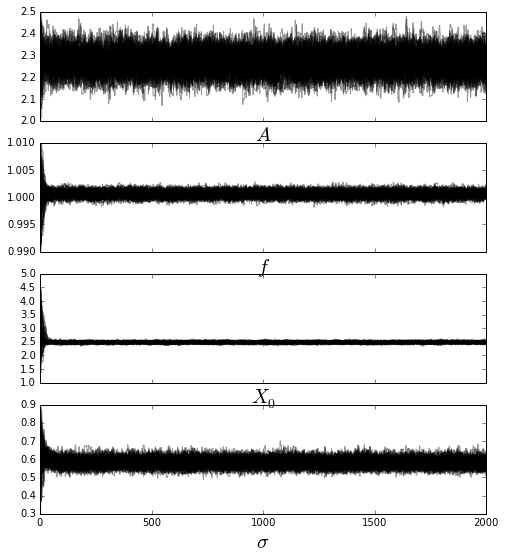

In [7]:
def PlotWalkers(sampler, symbols=None, alpha=0.4, color="k"):
    """ Plot all the chains from a sampler """
    nwalkers, nsteps, ndim = sampler.chain.shape

    fig, axes = plt.subplots(ndim, 1, sharex=True, figsize=(8, 9))

    for i in range(ndim):
        axes[i].plot(sampler.chain[:, :, i].T, color="k", alpha=alpha)
        if symbols:
            axes[i].set_xlabel(symbols[i])
            
symbols = ["$A$", "$f$", "$X_{0}$", "$\sigma$"]            
PlotWalkers(sampler, symbols=symbols)
plt.show()

We now can plot the marginal distributions in a so-called triangle plot. First "burning"
the first several hundred points before it seems to have 'converged'

In [ ]:
samples = sampler.chain[:, 1000:, :].reshape((-1, ndim))

fig = triangle.corner(samples, labels=symbols,
                      truths=[A, f, X0, sigma]
                      )


axes = fig.get_axes()
ax = axes[0]
def prior(x):
    return np.zeros(len(x)) + 7419.1
xlims = ax.get_xlim()
x = np.linspace(xlims[0], xlims[1], 100)
ax.plot(x, prior(x), "r", lw=10)
print ax.get_ylim(), ax.get_xlim()

plt.show()

This shows all the one and two-dimensional marginalisations of the posterior
probability distributions. The blue crosshairs indicate the real values which
were used to generate the fake data. Evidently we have been fairly successful
in recovering the correct parameters, but there remains some uncertainty in
the exact value. 

### Conclusion

This post illustrates the typical process of using Bayesian data analysis and
MCMC algorithm's to do parameter estimations for signals in noise. This is a
powerful method since provided the noise is stationary and Gaussian, we can
use any signal model $f(t, \vec{\theta})$ which can written as a python function.